# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW01] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def read_cancer_dataset(path_to_csv):
    data = pandas.read_csv(path_to_csv)
    data = data.reindex(np.random.permutation(data.index))
    X = data.drop('label', axis=1).values
    y = data.label.values
    temp = np.unique(y)
    y[y == temp[0]] = 0
    y[y == temp[1]] = 1
    return X, y

def read_spam_dataset(path_to_csv):
    data = pandas.read_csv(path_to_csv)
    data = data.reindex(np.random.permutation(data.index))
    X = data.drop('label', axis=1).values
    y = data.label.values
    temp = np.unique(y)
    y[y == temp[0]] = 0
    y[y == temp[1]] = 1
    return X, y

In [3]:
X, y = read_cancer_dataset("cancer.csv")

In [4]:
read_cancer_dataset("cancer.csv")

(array([[1.277e+01, 2.943e+01, 8.135e+01, ..., 6.498e-02, 2.407e-01,
         6.484e-02],
        [1.422e+01, 2.785e+01, 9.255e+01, ..., 8.219e-02, 1.890e-01,
         7.796e-02],
        [1.216e+01, 1.803e+01, 7.829e+01, ..., 5.690e-02, 2.406e-01,
         7.729e-02],
        ...,
        [1.403e+01, 2.125e+01, 8.979e+01, ..., 7.963e-02, 2.226e-01,
         7.617e-02],
        [1.245e+01, 1.570e+01, 8.257e+01, ..., 1.741e-01, 3.985e-01,
         1.244e-01],
        [2.171e+01, 1.725e+01, 1.409e+02, ..., 1.820e-01, 2.510e-01,
         6.494e-02]]),
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
 

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [5]:
def train_test_split(X, y, ratio):
    bound = round(ratio * X.shape[0])
    X_train, y_train, X_test, y_test = X[:bound], y[:bound], X[bound:], y[bound:]
    return X_train, y_train, X_test, y_test

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [6]:
def get_precision_recall_accuracy(y_pred, y_true):
    n_classes = len(np.unique(list(y_pred) + list(y_true)))
    tp, fp, fn = np.zeros(shape=(n_classes)), np.zeros(shape=(n_classes)), np.zeros(shape=(n_classes))
    t = y_true[y_true == y_pred]
    for i in t:
        tp[i] += 1
    f = y_pred[y_true != y_pred ]
    for i in f:
        fp[i] += 1
    f = y_true[y_true != y_pred ]
    for i in f:
        fn[i] += 1
    return tp / (tp + fp), tp / (tp + fn), t.size / y_true.size    

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [7]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [8]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [9]:
import heapq
from heapq import heappop
from heapq import heappush
from heapq import heappushpop

In [10]:
class Node(object):
    def __init__(self, coords=None, axis=None, left=None, right=None, data=None):
        self.coords = coords
        self.axis = axis
        self.left = left
        self.right = right
        self.data = data

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, i):
        return self.coords[i]
    

In [11]:
class KDTree:
    def __init__(self, X, leaf_size=40):
        def build_tree(X, idxs, axis=0):
            
            if X is None:
                return None
            
            n = X.shape[0]
            if n > leaf_size:
                median_idx = n // 2
                sort_idxs = np.argpartition(X[:,axis], median_idx)
                X = X[sort_idxs]
                idxs = idxs[sort_idxs]
                node_point = X[median_idx]
                next_axis = (axis + 1) % X.shape[1]

                return Node(node_point, axis, build_tree(X[:median_idx], idxs[:median_idx], next_axis),
                            build_tree(X[median_idx+1:], idxs[median_idx+1:], next_axis), idxs[median_idx])
            return Node(data=(X,idxs))
        
        self.root = build_tree(X.copy(), np.arange(X.shape[0]))
    
    @staticmethod
    def distance(x, y):
        return np.linalg.norm(x - y)   

    def k_nearest_neighbors(self, point, k):

        bests = []      
        
        def search(node):
            
            if node is None:
                return 
            # leaf
            if node.coords is None:
                for x, idx in zip(*node.data):
                    dist = -KDTree.distance(x, point)
                    if len(bests) < k:
                        heappush(bests, (dist, idx))
                    elif dist > bests[0][0]:
                        heappushpop(bests, (dist, idx))
            # not leaf
            else:
                dist = -KDTree.distance(node.coords, point)
                if len(bests) < k:
                    heappush(bests, (dist, node.data))
                elif dist > bests[0][0]:
                    heappushpop(bests, (dist, node.data)) 
                diff = point[node.axis] - node.coords[node.axis]
                sides = (node.left, node.right) if diff < 0 else (node.right, node.left)
                # closer side
                search(sides[0])
                # farther side
                if -abs(diff) > bests[0][0]:
                    search(sides[1])
        
        search(self.root)
        idx_bests = []
        while bests:
            idx_bests = [heappop(bests)[1]] + idx_bests
        return idx_bests    

    def query(self, X, k=1):
        return [self.k_nearest_neighbors(point,k) for point in X]            

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [12]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [13]:
class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.k = n_neighbors
        self.leaf_size = leaf_size
    
    def fit(self, X, y):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        X = (X - self.mean) / self.std
        
        self.kdtree = KDTree(X, self.leaf_size)
        self.labels = y
        self.n_classes = np.unique(y).size
        
    def predict_proba(self, X):
        X = (X - self.mean) / self.std
        predicted_probs = np.zeros(shape=(X.shape[0],self.n_classes))
        for i, point in enumerate(X):
            neighbors = self.kdtree.k_nearest_neighbors(point, self.k)
            for neighbor in neighbors:
                predicted_probs[i][y[neighbor]] += 1
        predicted_probs /= self.k
        
        return predicted_probs
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    

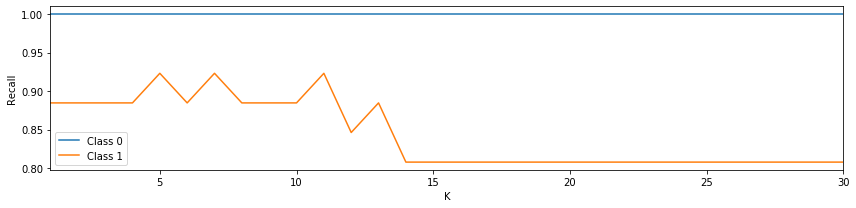

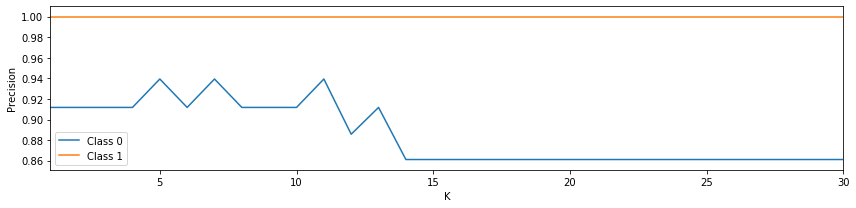

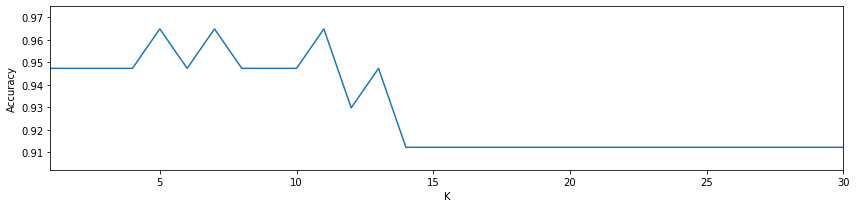

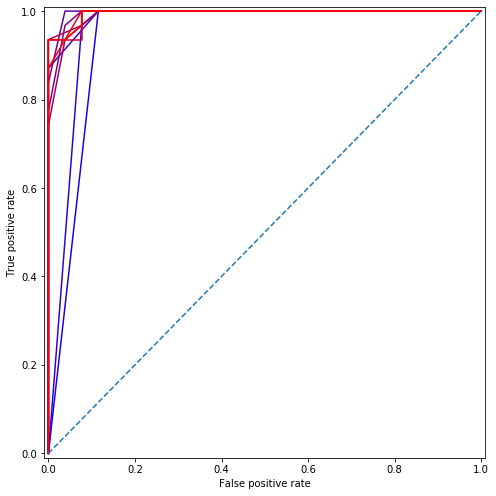

In [14]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

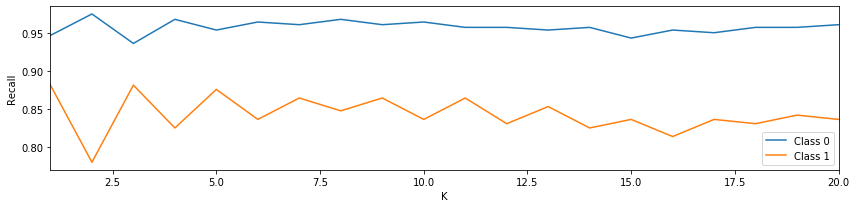

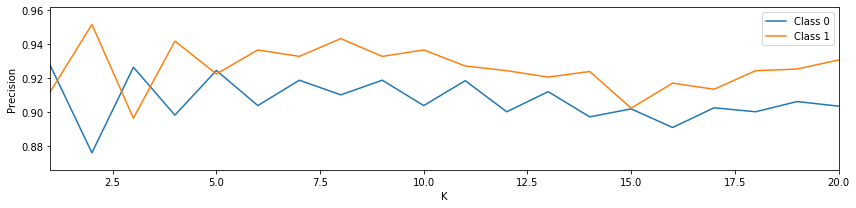

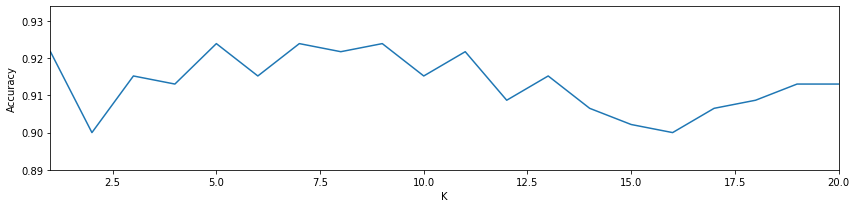

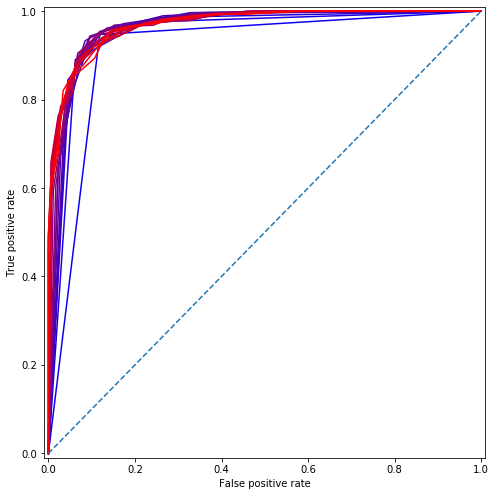

In [15]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)